Found 768 images belonging to 4 classes.
Found 192 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Epoch 1/20
12/12 - 26s - 2s/step - accuracy: 0.5260 - loss: 1.1275 - val_accuracy: 0.8021 - val_loss: 0.5705 - learning_rate: 1.0000e-03
Epoch 2/20
12/12 - 19s - 2s/step - accuracy: 0.7539 - loss: 0.6628 - val_accuracy: 0.7969 - val_loss: 0.4607 - learning_rate: 1.0000e-03
Epoch 3/20
12/12 - 18s - 2s/step - accuracy: 0.8060 - loss: 0.5249 - val_accuracy: 0.8802 - val_loss: 0.4058 - learning_rate: 1.0000e-03
Epoch 4/20
12/12 - 19s - 2s/step - accuracy: 0.8177 - loss: 0.4642 - val_accuracy: 0.8229 - val_loss: 0.4649 - learning_rate: 1.0000e-03
Epoch 5/20
12/12 - 20s - 2s/step - accuracy: 0.8359 - loss: 0.4368 - val_accuracy: 0.8021 - val_loss: 0.4365 - learning_rate: 1.0000e-03
Epoch 6/20
12/12 - 21s - 2s/step - accuracy: 0.8438 - loss: 0.3973 - val_accuracy: 0.8594 - val_loss: 0.3968 - learning_rate: 1.0000e-03
Epoch 7/20
12/12 - 21s - 2s/step - accuracy: 0.8659 - l

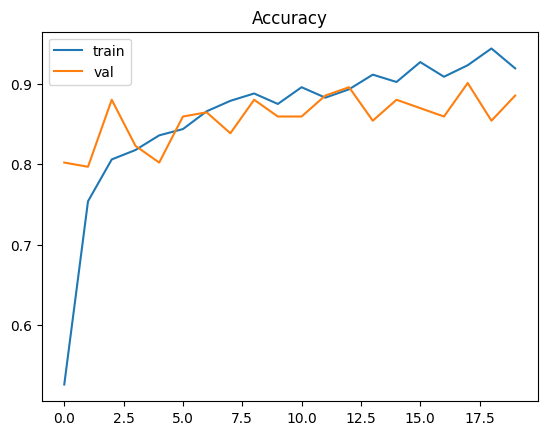

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 647ms/step - accuracy: 0.9100 - loss: 0.2686
Test accuracy: 0.9100


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define paths to your dataset
train_dir = r'geoguess/train'
test_dir = r'geoguess/test'

# Image parameters
img_height, img_width = 224, 224
batch_size = 64
num_classes = 4 

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)  
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Transfer Learning from MobileNetV2 
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  #

# Add custom classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Add callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
]


history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=2
)


###CHAT GPT CODE FOR FINE TUNING

# After initial training, unfreeze some layers for fine-tuning
def unfreeze_model(model):
    # We unfreeze the top layers of the base model
    base_model = model.layers[0]
    base_model.trainable = True
    
    # Fine-tune from this layer onwards
    fine_tune_at = 100
    
    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
        
    # Recompile with lower learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower LR
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Use after initial training
model = unfreeze_model(model)

# Continue training with even more patience
fine_tune_epochs = 10
total_epochs = 20 + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator,
    callbacks=callbacks
)






plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.title('Accuracy')
plt.show()

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")













